In [1]:
# pip install git+https://github.com/qiskit-community/qaoa_training_pipeline

In [2]:
from qaoa_training_pipeline.evaluation import MPSEvaluator
from qaoa_training_pipeline.utils.graph_utils import load_graph, graph_to_operator
import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def energy_fun(sol, graph):
    spin = {"0":-1, "1":+1}
    energy = 0
    for i , j in graph.edges():
        energy += graph[i][j]["weight"] * spin[sol[i]] * spin[sol[j]]
    return energy

In [4]:
nq = 60
graph_type = "1D"
backend_name = "qasm_simulator"
data = np.load(f"{nq}_{graph_type}.npy", allow_pickle=True).item()
graph = data["G"]
max_weight = max([data["G"][i][j]["weight"] for i, j in data["G"].edges()])

# QAOA training pipeline

In [14]:
optimal_energy = energy_fun(data["optimal"][0] if "optimal" in data else data["sol"][0], graph)
X = 10
cost_op = graph_to_operator(graph)
evaluator = MPSEvaluator(bond_dim_circuit=X)
delta_beta = 1
delta_gamma = -1

ps = data["ps"]
energies = []
times = []
for p in ps:
    print(f" p : {p}")
    start = time.time()
    betas = list(np.arange(1, p+1)[::-1] * delta_beta/p)
    gammas = list(np.arange(1, p+1) * delta_gamma/p) 
    energy = evaluator.evaluate(cost_op, betas + gammas)
    energies.append(energy)
    times.append(time.time() - start)
    print(f"energy: {energy}")
r = [-e/optimal_energy for e in energies]

 p : 3
energy: -17.337851393393816
 p : 4
energy: -19.46779915487762
 p : 5
energy: -20.957361695654143
 p : 6
energy: -21.123608292991452
 p : 7
energy: -21.622737800623717
 p : 8
energy: -22.038353823982348
 p : 9
energy: -22.200361465359563
 p : 10
energy: -22.522092347590853
 p : 13
energy: -22.925611543148303
 p : 15
energy: -23.189704825591
 p : 20
energy: -23.594492836986348
 p : 25
energy: -23.851426153008937
 p : 30
energy: -24.04035828167273
 p : 40
energy: -24.320887077591603
 p : 50
energy: -24.50476859745576
 p : 75
energy: -24.76348971315523
 p : 100
energy: -24.90580060925542


# Qiskit MPS

In [15]:
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit

In [16]:
import qiskit
import qiskit_aer
print("qiskit_aer version:", qiskit_aer.__version__)
print("qiskit version:", qiskit.__version__)

qiskit_aer version: 0.17.1
qiskit version: 1.4.4


In [17]:
χ = 10
backend = AerSimulator(method='matrix_product_state', matrix_product_state_max_bond_dimension = χ)

In [18]:
def maxcut_qaoa(betas, gammas, G):
    nq = G.number_of_nodes()
    qc = QuantumCircuit(nq, nq)
    qc.h(range(nq))
    layers = len(betas)
    for p in range(layers):
        for i, j in G.edges():
            qc.rzz(2 * gammas[p] * G[i][j]["weight"] , i, j)
        qc.rx(-2 * betas[p], range(nq))
    qc.measure(range(nq), reversed(range(nq)))
    return qc 

In [10]:
energy_mps_qiskit = []
for p in data["ps"]:
    print(f" p : {p}")
    betas = list(np.arange(1, p+1)[::-1] * delta_beta/p)
    gammas = list(np.arange(1, p+1) * delta_gamma/p) 
    qc = maxcut_qaoa(betas, gammas, graph)
    job = backend.run(qc, shots=1000)
    result = job.result()
    counts = result.get_counts(qc)
    e_i = sum([energy_fun(sol, graph) * count for sol, count in counts.items()]) / sum(counts.values())
    energy_mps_qiskit.append(e_i)
    print(f"energy: {round(e_i, 4)}")

 p : 3
energy: -17.4395
 p : 4
energy: -19.545
 p : 5
energy: -20.9116
 p : 6
energy: -21.165
 p : 7
energy: -21.5997
 p : 8
energy: -22.0131
 p : 9
energy: -22.2778
 p : 10
energy: -22.4492
 p : 13
energy: -22.9082
 p : 15
energy: -23.2087
 p : 20
energy: -23.6194
 p : 25
energy: -23.8378
 p : 30
energy: -24.023
 p : 40
energy: -24.3235
 p : 50
energy: -24.5184
 p : 75
energy: -24.7645
 p : 100
energy: -24.905


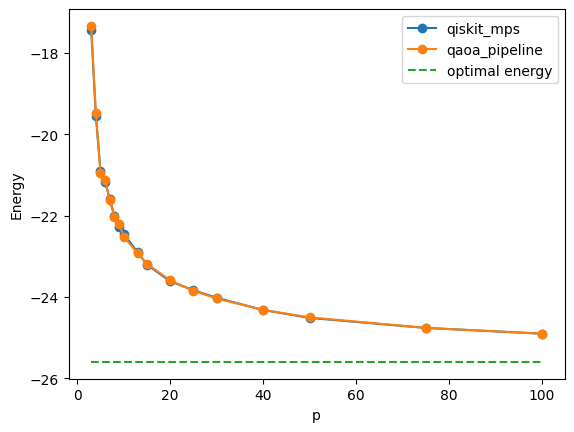

In [19]:
fig, ax  = plt.subplots()
ax.plot(data["ps"], energy_mps_qiskit, marker="o", label="qiskit_mps")
ax.plot(data["ps"], energies, marker="o", label=f"qaoa_pipeline")
ax.plot(data["ps"], [optimal_energy]*len(data["ps"]), label="optimal energy", linestyle="--")
ax.set_xlabel("p")
ax.set_ylabel("Energy")
ax.legend()